# Bayesian black-box model-predictive control

An Expected Free Energy minimizing agent based on a nonlinear autoregressive model with exogenous input.

## System: driven damped pendulum

Consider a single pendulum with angle $\theta(t)$ and input $u(t)$ evolving according to:

$$ \ddot{\theta} + \frac{\mathcal{g}}{l} \sin(\theta) + \frac{\gamma}{l} \dot{\theta} = \frac{1}{ml} u\, .$$

where $m$ is mass, $l$ is length, $\gamma$ is damping and $\mathcal{g}$ is Earth's gravity.

In [1]:
using Revise
using Optim
using RxInfer
using JLD
using SpecialFunctions
using LinearAlgebra
using ProgressMeter
using Distributions
using Plots; default(grid=false, label="", linewidth=3,margin=20Plots.pt)

includet("../NARXAgents.jl"); using .NARXAgents
includet("../Pendulums.jl"); using .Pendulums
includet("../location_scale_tdist.jl"); using .location_scale_tdist

In [2]:
# System parameters
sys_mass = 2.0
sys_length = 0.5
sys_damping = 0.2
sys_mnoise_sd = 1e-2
sys_ulims = (-40., 40.)
Δt = 0.2

init_state = [0.0, 0.0]
pendulum = SPendulum(init_state = init_state, 
                     mass = sys_mass, 
                     length = sys_length, 
                     damping = sys_damping, 
                     mnoise_sd = sys_mnoise_sd, 
                     torque_lims = sys_ulims,
                     Δt=Δt)

SPendulum([0.0, 0.0], -0.004836532998084434, 0.0, (-40.0, 40.0), 0.2, 2.0, 0.5, 0.2, 0.01)

In [3]:
N = 100
tsteps = range(0.0, step=Δt, length=N)

0.0:0.2:19.8

In [4]:
# Inputs
A  = rand(10)*300 .- 100
Ω  = rand(10)*3
controls = mean([A[i]*sin.(Ω[i].*tsteps) for i = 1:10]) ./ 10;

In [5]:
states = zeros(2,N)
observations = zeros(N)
torques = zeros(N)

for k in 1:N
    states[:,k] = pendulum.state
    observations[k] = pendulum.sensor
    step!(pendulum, controls[k])
    torques[k] = pendulum.torque
end

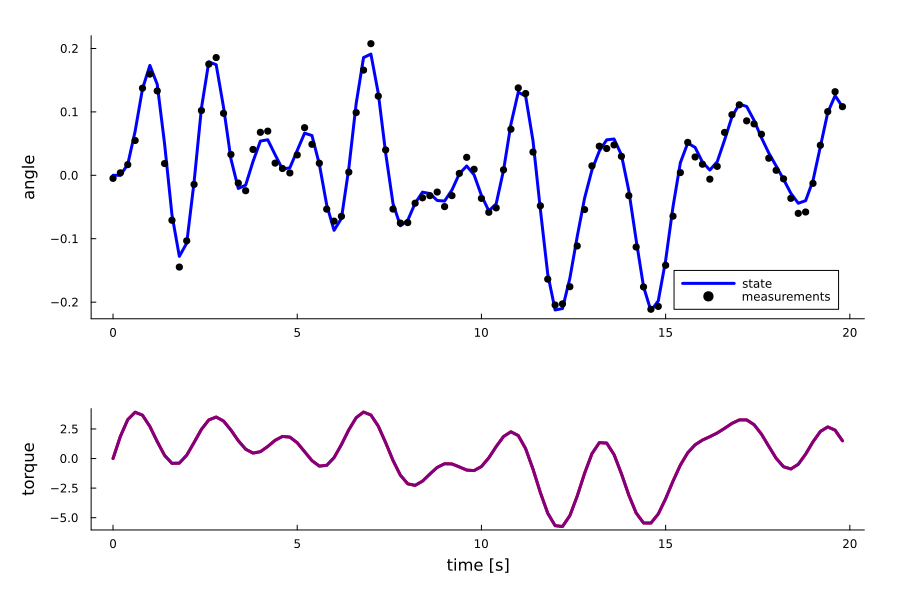

In [6]:
p1 = plot(ylabel="angle")
plot!(tsteps, states[1,:], color="blue", label="state")
scatter!(tsteps, observations, color="black", label="measurements")
p2 = plot(xlabel="time [s]", ylabel="torque")
plot!(tsteps, controls[:], color="red")
plot!(tsteps, torques[:], color="purple")
plot(p1,p2, layout=grid(2,1, heights=[0.7, 0.3]), size=(900,600))

## Experiments

In [7]:
# Experiment specification 
N = 100
tsteps = range(0.0, step=Δt, length=N)
T = 5

# NARX basis settings
H = 2
Ly = 2
Lu = 2
M = size(pol(zeros(Ly+Lu+1), degree=H),1);

# System specification
init_state = [0.0, 0.0];

# Agent specification
α0 = 1e6 # Must be larger than 1.0 
β0 = 1e-4
μ0 = 1e-8*randn(M)
Λ0 = 1e-2diagm(ones(M))
η  = 1e-6

1.0e-6

In [8]:
[mean(Gamma(α0, β0)) var(Gamma(α0, β0))]

1×2 Matrix{Float64}:
 100.0  0.01

### Expected Free Energy minimization

In [9]:
pendulum = SPendulum(init_state = init_state, 
                     mass = sys_mass, 
                     length = sys_length, 
                     damping = sys_damping, 
                     mnoise_sd = sys_mnoise_sd, 
                     torque_lims = sys_ulims,
                     Δt=Δt)

# Set goal priors for time horizon
goals = [Normal(3.14, 0.1) for t in 1:T]

# Start agent
agent = NARXAgent(μ0, Λ0, α0, β0,
                  goal_prior=goals, 
                  delay_inp=Lu, 
                  delay_out=Ly, 
                  pol_degree=H,
                  time_horizon=T)   
                  
yb = zeros(Ly)
ub = zeros(Lu+1)

uu = range(-40, stop=40., length=300)
J1 = [mutualinfo(agent, yb, ub, u_) for u_ in uu]
J2 = [crossentropy(agent, yb, ub, goals[1], u_) for u_ in uu]

300-element Vector{Float64}:
 494.26083345315135
 494.2269177535598
 494.1936802007647
 494.16111169314803
 494.1292031905897
 494.09794571446685
 494.06733034765404
 494.03734823452294
 494.00799058094316
 493.97924865428155
   ⋮
 494.0077618031089
 494.0371178398844
 494.06709833621125
 494.09771208621993
 494.12896794553865
 494.16087483129274
 494.19344172210515
 494.2266776580962
 494.2605917408835

In [10]:
tmp1 = zeros(length(uu))
tmp2 = zeros(length(uu))
for (jj,u_) in enumerate(uu)
    ub2 = backshift(ub, u_)
    ϕ_ = pol([yb; ub2], degree=agent.pol_degree)
    _, tmp1[jj], tmp2[jj] = posterior_predictive(agent, ϕ_)
end

In [11]:
tmp1

300-element Vector{Float64}:
 -1.0085143026061288e-7
 -1.0213149390907434e-7
 -1.0338568780392956e-7
 -1.0461401194517852e-7
 -1.0581646633282124e-7
 -1.0699305096685776e-7
 -1.0814376584728792e-7
 -1.0926861097411188e-7
 -1.1036758634732965e-7
 -1.1144069196694112e-7
  ⋮
  6.182243014526637e-7
  6.244723361036198e-7
  6.307462405081824e-7
  6.370460146663509e-7
  6.43371658578126e-7
  6.49723172243507e-7
  6.561005556624946e-7
  6.625038088350883e-7
  6.689329317612882e-7

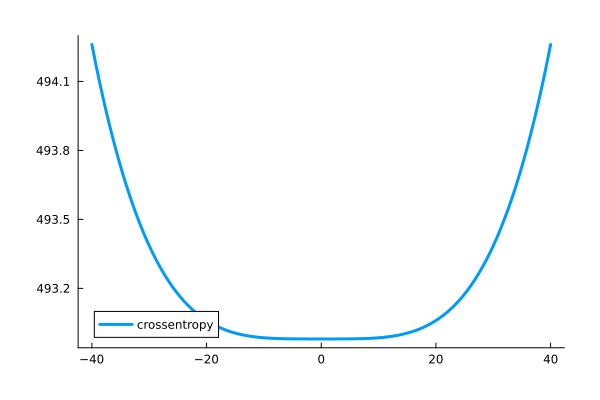

In [12]:
plot(uu, J2, label="crossentropy")
# plot!(uu, J1, label="mutual info")

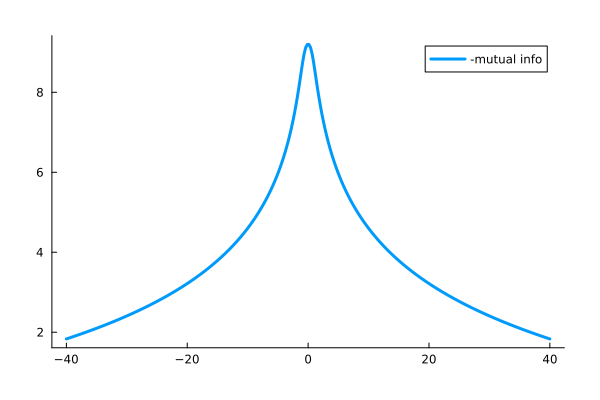

In [13]:
plot(uu, -J1, label="-mutual info")

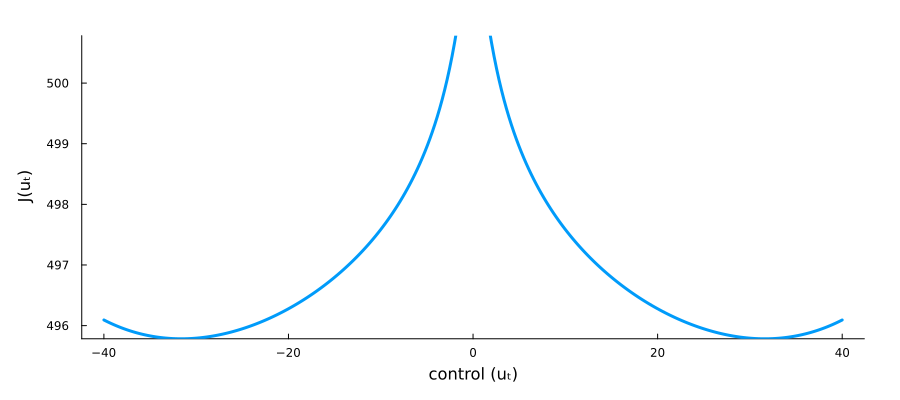

In [14]:
J0 = J2-J1
plot(uu, J0, xlabel="control (uₜ)", ylabel="J(uₜ)", size=(900,400), ylims=(minimum(J0), minimum(J0)+5))

In [15]:
# Start system
pendulum = SPendulum(init_state = init_state, 
                     mass = sys_mass, 
                     length = sys_length, 
                     damping = sys_damping, 
                     mnoise_sd = sys_mnoise_sd, 
                     torque_lims = sys_ulims,
                     Δt=Δt)

# Set goal priors for time horizon
goals = [Normal(3.141592, 0.1) for t in 1:T]

# Start agent
agent = NARXAgent(μ0, Λ0, α0, β0,
                  goal_prior=goals, 
                  delay_inp=Lu, 
                  delay_out=Ly, 
                  pol_degree=H,
                  time_horizon=T,
                  control_prior_precision=η)

# Preallocate
y_EFE = zeros(N)
z_EFE = zeros(2,N)
u_EFE = zeros(N+T)
μ_EFE = [μ0]
Λ_EFE = [Λ0]
α_EFE = [α0]
β_EFE = [β0]
F_EFE = zeros(N)
pred_m = zeros(N,T)
pred_v = zeros(N,T)
dJ_MI = zeros(N)
dJ_CE = zeros(N)
dJ_CC = zeros(N)
MI = zeros(N,T)
CE = zeros(N,T)
Nu = 200
J_MI = zeros(N,Nu)
J_CE = zeros(N,Nu)
urange = range(sys_ulims[1], stop=sys_ulims[2], length=Nu)

@showprogress for k in 1:N    
    
    # Update parameter beliefs
    y_EFE[k] = pendulum.sensor
    NARXAgents.update!(agent, y_EFE[k], u_EFE[k])
    F_EFE[k] = agent.free_energy
    push!( μ_EFE, agent.μ )
    push!( Λ_EFE, agent.Λ )
    push!( α_EFE, agent.α )
    push!( β_EFE, agent.β )
    
    # Optimal control
    policy = minimizeEFE(agent, goals, u_0=-1e-8*rand(T), control_lims=sys_ulims)
    u_EFE[k+1:k+T] = policy

    # Track EFE terms
    dJ_MI[k], dJ_CE[k], dJ_CC[k] = EFE_balance(agent, goals[1], u_EFE[k])

    MI[k,:] = [mutualinfo(agent, agent.ybuffer, agent.ubuffer, u_t) for u_t in policy]
    CE[k,:] = [crossentropy(agent, agent.ybuffer, agent.ubuffer, goals[1], u_t) for u_t in policy]

    J_MI[k,:] = [mutualinfo(agent, agent.ybuffer, agent.ubuffer, u_i) for u_i in urange]
    J_CE[k,:] = [crossentropy(agent, agent.ybuffer, agent.ubuffer, goals[1], u_i) for u_i in urange]
    
    # Store future predictions
    pred_m[k,:], pred_v[k,:] = predictions(agent, policy, time_horizon=T)

    # Act upon environment
    step!(pendulum, u_EFE[k+1])
    z_EFE[:,k] = pendulum.state
    
end

Progress:   2%|▉                                        |  ETA: 0:07:12

Progress:   4%|█▋                                       |  ETA: 0:04:00

Progress:   8%|███▎                                     |  ETA: 0:01:56

Progress:  11%|████▌                                    |  ETA: 0:01:23

Progress:  13%|█████▍                                   |  ETA: 0:01:10

Progress:  15%|██████▏                                  |  ETA: 0:01:00

Progress:  17%|███████                                  |  ETA: 0:00:52

Progress:  19%|███████▊                                 |  ETA: 0:00:46

Progress:  21%|████████▋                                |  ETA: 0:00:41

Progress:  23%|█████████▍                               |  ETA: 0:00:37

Progress:  25%|██████████▎                              |  ETA: 0:00:34

Progress:  27%|███████████▏                             |  ETA: 0:00:31

Progress:  30%|████████████▎                            |  ETA: 0:00:27

Progress:  37%|███████████████▏                         |  ETA: 0:00:20

Progress:  39%|████████████████                         |  ETA: 0:00:19

Progress:  41%|████████████████▊                        |  ETA: 0:00:18

Progress:  45%|██████████████████▌                      |  ETA: 0:00:15

Progress:  47%|███████████████████▎                     |  ETA: 0:00:15

Progress:  48%|███████████████████▋                     |  ETA: 0:00:14

Progress:  49%|████████████████████▏                    |  ETA: 0:00:14

Progress:  50%|████████████████████▌                    |  ETA: 0:00:13

Progress:  52%|█████████████████████▍                   |  ETA: 0:00:13

Progress:  54%|██████████████████████▏                  |  ETA: 0:00:12

Progress:  55%|██████████████████████▌                  |  ETA: 0:00:11

Progress:  56%|███████████████████████                  |  ETA: 0:00:11

Progress:  58%|███████████████████████▊                 |  ETA: 0:00:10

Progress:  60%|████████████████████████▋                |  ETA: 0:00:10

Progress:  62%|█████████████████████████▍               |  ETA: 0:00:09

Progress:  64%|██████████████████████████▎              |  ETA: 0:00:09

Progress:  67%|███████████████████████████▌             |  ETA: 0:00:08

Progress:  70%|████████████████████████████▊            |  ETA: 0:00:07

Progress:  72%|█████████████████████████████▌           |  ETA: 0:00:06

Progress:  75%|██████████████████████████████▊          |  ETA: 0:00:05

Progress:  78%|████████████████████████████████         |  ETA: 0:00:04

Progress:  81%|█████████████████████████████████▎       |  ETA: 0:00:04

Progress:  85%|██████████████████████████████████▉      |  ETA: 0:00:03

Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:02

Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:02

Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:01

Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:01

Progress:  98%|████████████████████████████████████████▏|  ETA: 0:00:00

Progress: 100%|█████████████████████████████████████████| Time: 0:00:16


In [46]:
save("results/EFE.jld", "y_EFE", y_EFE, "z_EFE", z_EFE, "u_EFE", u_EFE, 
    "pred_m", pred_m, "pred_v", pred_v, "goals_m", mean.(goals), "goals_v", var.(goals),
    "sys_ulims", sys_ulims, "tsteps", tsteps, "T", T)

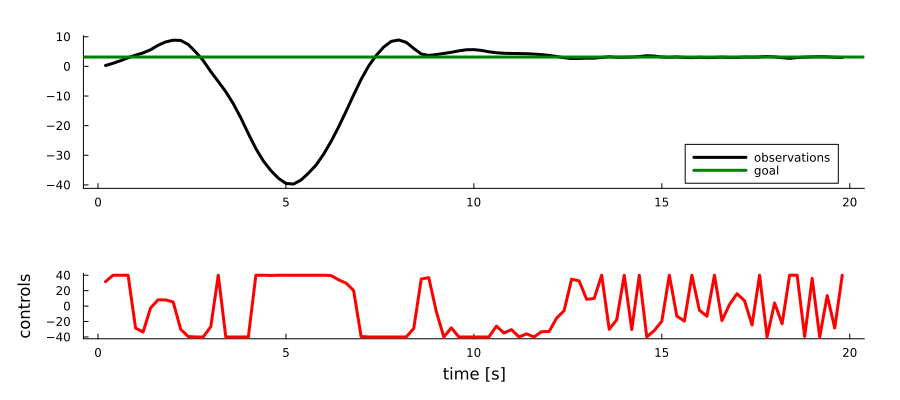

In [17]:
p1 = plot(tsteps[2:end], y_EFE[2:end], color="black", label="observations")
hline!([mean(goals[1])], color="green", label="goal")
# vline!([cut_gvar], color="orange", label="change in goal prior var")
p4 = plot(tsteps[2:end], u_EFE[2:end-T], color="red", ylabel="controls", xlabel="time [s]")

plot(p1,p4, layout=grid(2,1, heights=[.7, .3]), size=(900,400))

In [18]:
savefig("figures/NARX-EFE-1Pendulum-trial.png")

"/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/ACC2024-NARXEFE/pendulumswing/figures/NARX-EFE-1Pendulum-trial.png"

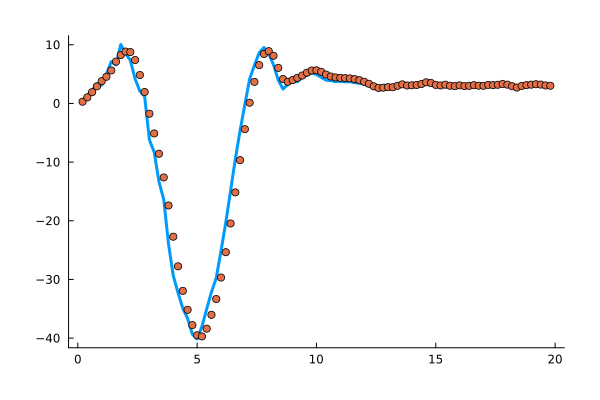

In [19]:
plot(tsteps[2:end], pred_m[2:end,1], ribbon=sqrt.(pred_v[2:end,1]))
scatter!(tsteps[2:end], y_EFE[2:end] )

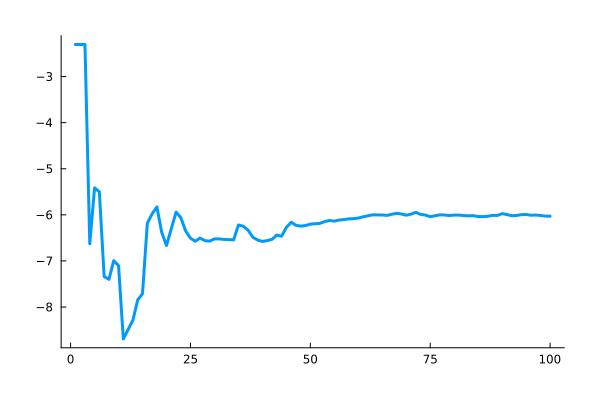

In [20]:
plot(MI[:,1])

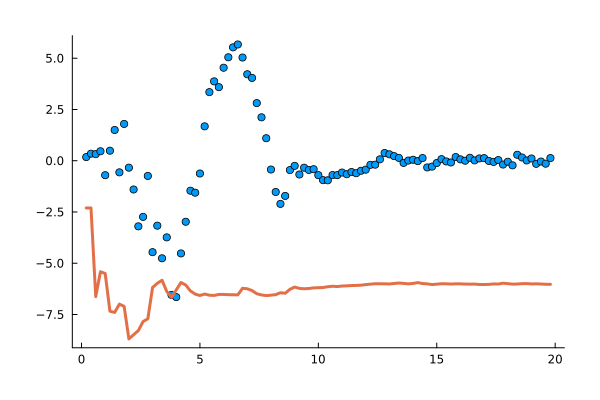

In [21]:
scatter(tsteps[2:end], pred_m[2:end,1] .- y_EFE[2:end])
plot!(tsteps[2:end], MI[2:end,1])

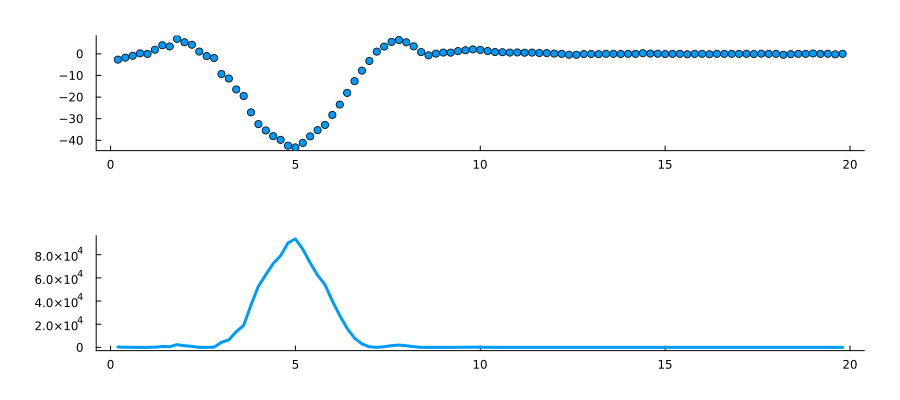

In [22]:
p331 = scatter(tsteps[2:end], pred_m[2:end,1] .- mean(goals[1]))
p332 = plot(tsteps[2:end], CE[2:end,1])
plot(p331, p332, layout=(2,1), size=(900,400))

┌ Warning: No strict ticks found
└ @ PlotUtils /home/wmkouw/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils /home/wmkouw/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191
┌ Warning: Invalid negative or zero value -2.3042758386595423 found at series index 1 for log10 based yscale
└ @ Plots /home/wmkouw/.julia/packages/Plots/sxUvK/src/utils.jl:106
┌ Warning: No strict ticks found
└ @ PlotUtils /home/wmkouw/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191


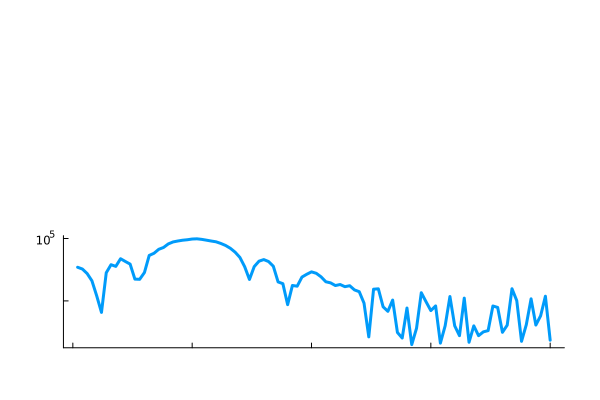

┌ Warning: No strict ticks found
└ @ PlotUtils /home/wmkouw/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191
┌ Warning: Invalid negative or zero value -2.3042758386595423 found at series index 1 for log10 based yscale
└ @ Plots /home/wmkouw/.julia/packages/Plots/sxUvK/src/utils.jl:106
┌ Warning: No strict ticks found
└ @ PlotUtils /home/wmkouw/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils /home/wmkouw/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils /home/wmkouw/.julia/packages/PlotUtils/mHQ0Q/src/ticks.jl:191
┌ Warning: Invalid negative or zero value -2.3042758386595423 found at series index 1 for log10 based yscale
└ @ Plots /home/wmkouw/.julia/packages/Plots/sxUvK/src/utils.jl:106


In [23]:
p331 = plot(MI[:,1], yscale=:log10)
p332 = plot(CE[:,1], yscale=:log10)
plot(p331, p332, layout=(2,1) )

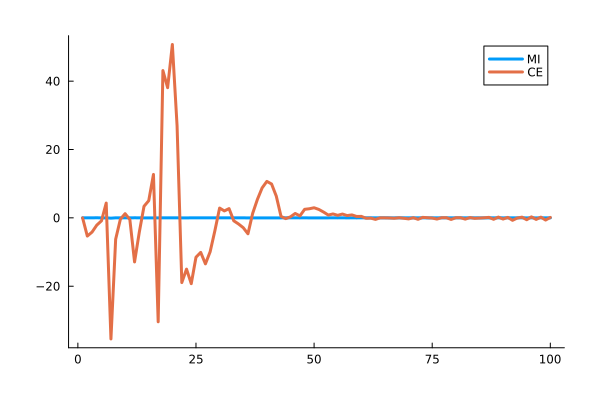

In [24]:
plot(dJ_MI, label="MI")
plot!(dJ_CE, label="CE", )

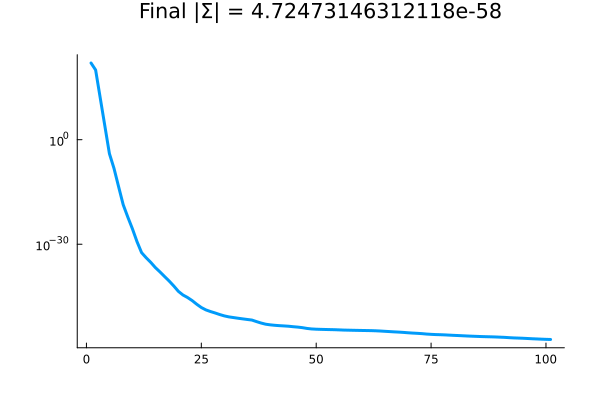

In [25]:
dSθ_EFE = det.(inv.(Λ_EFE))
final_dSθ_EFE = dSθ_EFE[end]
plot(dSθ_EFE, title="Final |Σ| = $final_dSθ_EFE", yscale=:log10)

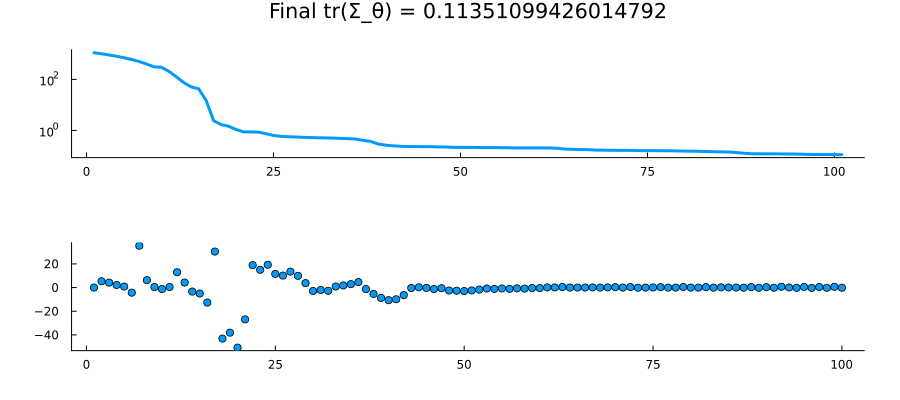

In [26]:
trSθ_EFE = tr.(inv.(Λ_EFE))
final_trSθ_EFE = trSθ_EFE[end]
p81 = plot(trSθ_EFE, title="Final tr(Σ_θ) = $final_trSθ_EFE", yscale=:log10)
p82 = scatter(dJ_MI - dJ_CE)
plot(p81, p82, layout=(2,1), size=(900,400))

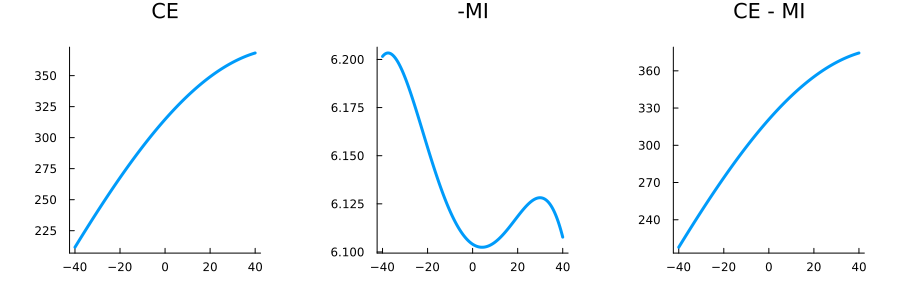

In [27]:
ix = 50
p441 = plot(urange, J_CE[ix,:], title="CE")
p442 = plot(urange, -J_MI[ix,:], title="-MI")
p443 = plot(urange, J_CE[ix,:] .- J_MI[ix,:], title="CE - MI")
plot(p441, p442, p443, layout=(1,3), size=(900,300))

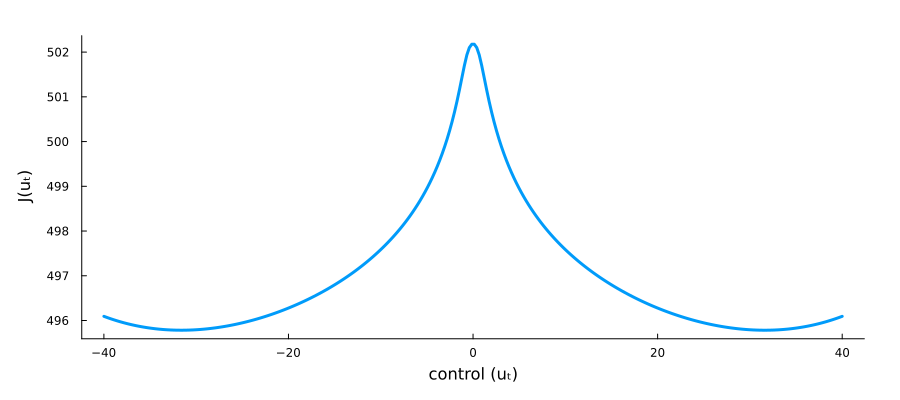

In [28]:
J0 = J2-J1
plot(uu, J0, xlabel="control (uₜ)", ylabel="J(uₜ)", size=(900,400))

┌ Info: Saved animation to /home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/ACC2024-NARXEFE/pendulumswing/figures/NARX-EFE-1Pendulum-planning.gif
└ @ Plots /home/wmkouw/.julia/packages/Plots/sxUvK/src/animation.jl:156


Plots.AnimatedGif("/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/ACC2024-NARXEFE/pendulumswing/figures/NARX-EFE-1Pendulum-planning.gif")
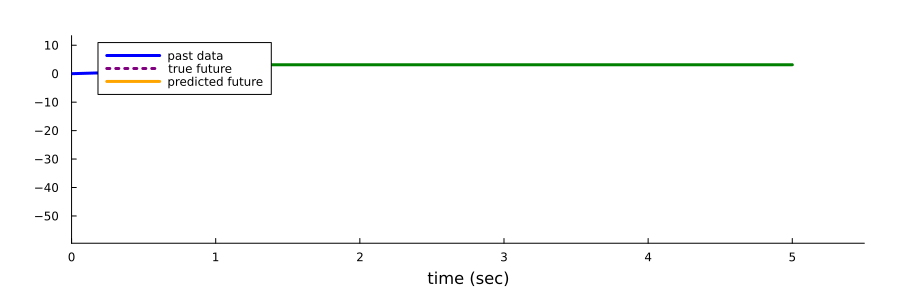

In [29]:
limsb = [minimum(y_EFE)*1.5, maximum(y_EFE)*1.5]

window = 20

anim = @animate for k in 2:2:(N-T-1)
    
    if k <= window
        plot(tsteps[1:k], y_EFE[1:k], color="blue", xlims=(tsteps[1], tsteps[window+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_EFE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], pred_m[k,:], ribbon=pred_v[k,:], label="predicted future", color="orange", legend=:topleft)
        plot!(mean.(goals), color="green")
    else
        plot(tsteps[k-window:k], y_EFE[k-window:k], color="blue", xlims=(tsteps[k-window], tsteps[k+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_EFE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], pred_m[k,:], ribbon=pred_v[k,:], label="prediction", color="orange", legend=:topleft)
        plot!(mean.(goals), color="green")
    end
    
end
gif(anim, "figures/NARX-EFE-1Pendulum-planning.gif", fps=24)

### Mean Squared Error minimization

In [30]:
# Start system
pendulum = SPendulum(init_state = init_state, 
                     mass = sys_mass, 
                     length = sys_length, 
                     damping = sys_damping, 
                     mnoise_sd = sys_mnoise_sd, 
                     torque_lims = sys_ulims,
                     Δt=Δt)

# Start agent
agent = NARXAgent(μ0, Λ0, α0, β0,
                  goal_prior=goals, 
                  delay_inp=Lu, 
                  delay_out=Ly, 
                  pol_degree=H,
                  time_horizon=T,
                  control_prior_precision=η)

# Preallocate
y_MSE = zeros(N)
z_MSE = zeros(2,N)
u_MSE = zeros(N+T)
μ_MSE = [μ0]
Λ_MSE = [Λ0]
α_MSE = [α0]
β_MSE = [β0]
F_MSE = zeros(N)
pred_m = zeros(N,T)
pred_v = zeros(N,T)

@showprogress for k in 1:N    
    
    # Update parameter beliefs
    y_MSE[k] = pendulum.sensor
    NARXAgents.update!(agent, y_MSE[k], u_MSE[k])
    F_MSE[k] = agent.free_energy
    push!(μ_MSE, agent.μ )
    push!(Λ_MSE, agent.Λ )
    push!(α_MSE, agent.α )
    push!(β_MSE, agent.β )
    
    # Optimal control
    policy = minimizeMSE(agent, goals, u_0=u_EFE[k:k+T-1], control_lims=sys_ulims)
    u_MSE[k+1:k+T] = policy
    
    # Store future predictions
    pred_m[k,:], pred_v[k,:] = predictions(agent, policy, time_horizon=T)

    # Act upon environment
    step!(pendulum, u_MSE[k+1])
    z_MSE[:,k] = pendulum.state
    
end

Progress:   2%|▉                                        |  ETA: 0:09:29

Progress:  12%|████▉                                    |  ETA: 0:03:57

Progress:  13%|█████▍                                   |  ETA: 0:04:43

Progress:  14%|█████▊                                   |  ETA: 0:05:21

Progress:  15%|██████▏                                  |  ETA: 0:05:53

Progress:  16%|██████▌                                  |  ETA: 0:06:20

Progress:  17%|███████                                  |  ETA: 0:06:42

Progress:  18%|███████▍                                 |  ETA: 0:07:01

Progress:  19%|███████▊                                 |  ETA: 0:07:16

Progress:  20%|████████▎                                |  ETA: 0:06:53

Progress:  21%|████████▋                                |  ETA: 0:07:06

Progress:  22%|█████████                                |  ETA: 0:07:17

Progress:  32%|█████████████▏                           |  ETA: 0:05:37

Progress:  33%|█████████████▌                           |  ETA: 0:05:42

Progress:  34%|██████████████                           |  ETA: 0:05:46

Progress:  35%|██████████████▍                          |  ETA: 0:05:50

Progress:  36%|██████████████▊                          |  ETA: 0:05:53

Progress:  37%|███████████████▏                         |  ETA: 0:05:56

Progress:  39%|████████████████                         |  ETA: 0:05:27

Progress:  40%|████████████████▍                        |  ETA: 0:05:14

Progress:  41%|████████████████▊                        |  ETA: 0:05:03

Progress:  42%|█████████████████▎                       |  ETA: 0:05:04

Progress:  45%|██████████████████▌                      |  ETA: 0:04:30

Progress:  46%|██████████████████▉                      |  ETA: 0:04:19

Progress:  47%|███████████████████▎                     |  ETA: 0:04:10

Progress:  48%|███████████████████▋                     |  ETA: 0:04:00

Progress:  52%|█████████████████████▍                   |  ETA: 0:03:52

Progress:  53%|█████████████████████▊                   |  ETA: 0:03:50

Progress:  54%|██████████████████████▏                  |  ETA: 0:03:50

Progress:  55%|██████████████████████▌                  |  ETA: 0:03:49

Progress:  56%|███████████████████████                  |  ETA: 0:03:48

Progress:  57%|███████████████████████▍                 |  ETA: 0:03:47

Progress:  58%|███████████████████████▊                 |  ETA: 0:03:45

Progress:  59%|████████████████████████▎                |  ETA: 0:03:43

Progress:  64%|██████████████████████████▎              |  ETA: 0:03:00

Progress:  67%|███████████████████████████▌             |  ETA: 0:02:48

Progress:  68%|███████████████████████████▉             |  ETA: 0:02:45

Progress:  69%|████████████████████████████▎            |  ETA: 0:02:41

Progress:  70%|████████████████████████████▊            |  ETA: 0:02:38

Progress:  71%|█████████████████████████████▏           |  ETA: 0:02:34

Progress:  72%|█████████████████████████████▌           |  ETA: 0:02:31

Progress:  73%|█████████████████████████████▉           |  ETA: 0:02:24

Progress:  74%|██████████████████████████████▍          |  ETA: 0:02:21

Progress:  77%|███████████████████████████████▋         |  ETA: 0:02:06

Progress:  78%|████████████████████████████████         |  ETA: 0:02:01

Progress:  79%|████████████████████████████████▍        |  ETA: 0:01:57

Progress:  80%|████████████████████████████████▊        |  ETA: 0:01:53

Progress:  83%|██████████████████████████████████       |  ETA: 0:01:32

Progress:  85%|██████████████████████████████████▉      |  ETA: 0:01:21

Progress:  86%|███████████████████████████████████▎     |  ETA: 0:01:17

Progress:  87%|███████████████████████████████████▋     |  ETA: 0:01:12

Progress:  88%|████████████████████████████████████▏    |  ETA: 0:01:07

Progress:  89%|████████████████████████████████████▌    |  ETA: 0:01:02

Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:57

Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:45

Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:40

Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:35

Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:29

Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:23

Progress:  97%|███████████████████████████████████████▊ |  ETA: 0:00:18

Progress:  98%|████████████████████████████████████████▏|  ETA: 0:00:12

Progress:  99%|████████████████████████████████████████▋|  ETA: 0:00:06

Progress: 100%|█████████████████████████████████████████| Time: 0:10:00


In [39]:
save("results/MSE.jld", "y_MSE", y_MSE, "z_MSE", z_MSE, "u_MSE", u_MSE, "pred_m", pred_m, "pred_v", pred_v)

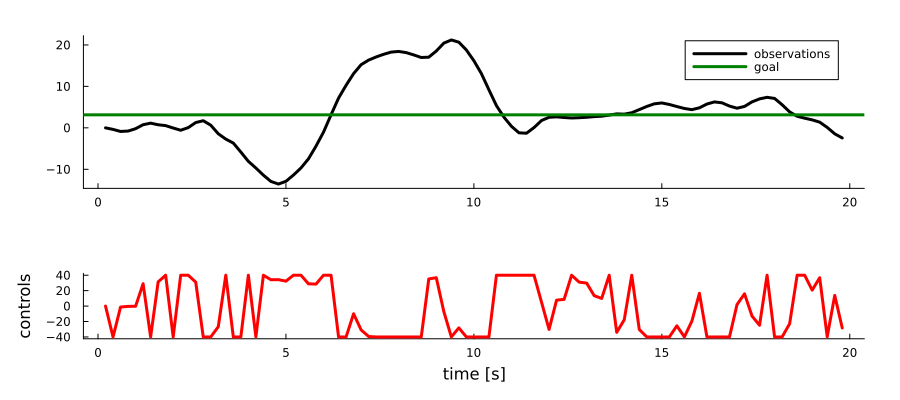

In [32]:
p1 = plot(tsteps[2:end], y_MSE[2:end], color="black", label="observations")
hline!([mean(goals[1])], color="green", label="goal")
p4 = plot(tsteps[2:end], u_MSE[2:end-T], color="red", ylabel="controls", xlabel="time [s]")

plot(p1,p4, layout=grid(2,1, heights=[.7, .3]), size=(900,400))

In [33]:
savefig("figures/NARX-MSE-1Pendulum-trial.png")

"/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/ACC2024-NARXEFE/pendulumswing/figures/NARX-MSE-1Pendulum-trial.png"

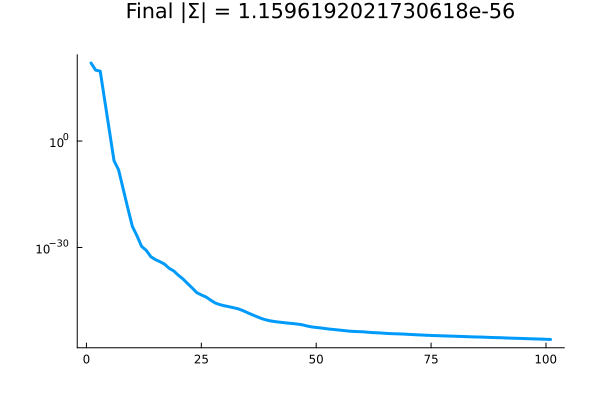

In [34]:
dSθ_MSE = det.(inv.(Λ_MSE))
final_dSθ_MSE = dSθ_MSE[end]
plot(dSθ_MSE, title="Final |Σ| = $final_dSθ_MSE", yscale=:log10)

┌ Info: Saved animation to /home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/ACC2024-NARXEFE/pendulumswing/figures/NARX-MSE-1Pendulum-planning.gif
└ @ Plots /home/wmkouw/.julia/packages/Plots/sxUvK/src/animation.jl:156


Plots.AnimatedGif("/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/efe-acquisition/ACC2024-NARXEFE/pendulumswing/figures/NARX-MSE-1Pendulum-planning.gif")
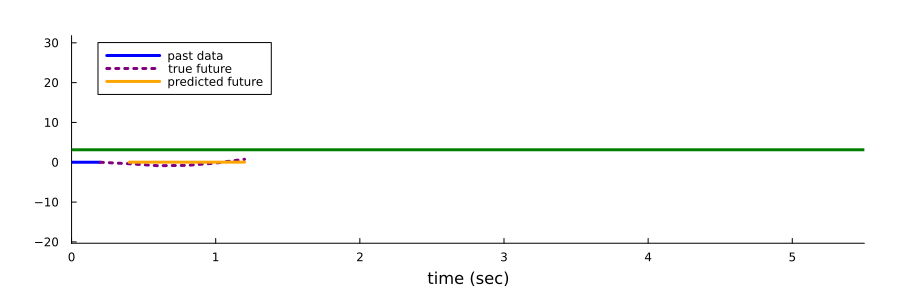

In [35]:
limsb = [minimum(y_MSE)*1.5, maximum(y_MSE)*1.5]

window = 20

anim = @animate for k in 2:2:(N-T-1)
    
    if k <= window
        plot(tsteps[1:k], y_MSE[1:k], color="blue", xlims=(tsteps[1], tsteps[window+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_MSE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], pred_m[k,:], ribbon=pred_v[k,:], label="predicted future", color="orange", legend=:topleft)
        hline!([mean(goals[1])], color="green")
    else
        plot(tsteps[k-window:k], y_MSE[k-window:k], color="blue", xlims=(tsteps[k-window], tsteps[k+T+1]+0.5), label="past data", xlabel="time (sec)", ylims=limsb, size=(900,300))
        plot!(tsteps[k:k+T], y_MSE[k:k+T], color="purple", label="true future", linestyle=:dot)
        plot!(tsteps[k+1:k+T], pred_m[k,:], ribbon=pred_v[k,:], label="prediction", color="orange", legend=:topleft)
        hline!([mean(goals[1])], color="green")
    end
    
end
gif(anim, "figures/NARX-MSE-1Pendulum-planning.gif", fps=24)

### Comparisons

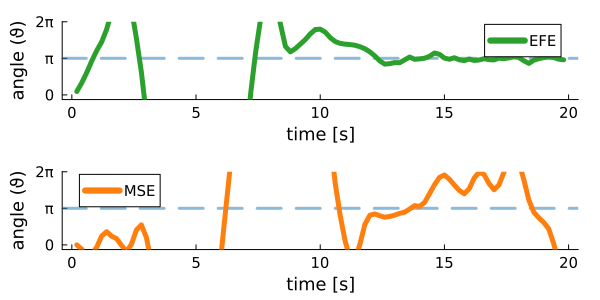

In [36]:
p1 = hline([mean(goals[1])], color=palette(:tab10)[1], linestyle=:dash, alpha=0.5, ylims=(-.4, 2π), yticks=([0, 3.1415, 6.2830],[0, "π",  "2π"]), label="", xlabel="time [s]", ylabel="angle (ϑ)", guidefontsize=12, legendfontsize=10, tickfontsize=10)
plot!(tsteps[2:end], y_MSE[2:end], linewidth=5, color=palette(:tab10)[2], label="MSE")

p2 = hline([mean(goals[1])], color=palette(:tab10)[1], linestyle=:dash, alpha=0.5, ylims=(-.4, 2π), yticks=([0, 3.1415, 6.2830],[0, "π",  "2π"]), label="", xlabel="time [s]", ylabel="angle (ϑ)", guidefontsize=12, legendfontsize=10, tickfontsize=10)
plot!(tsteps[2:end], y_EFE[2:end], linewidth=5, color=palette(:tab10)[3], label="EFE")

plot(p2,p1, layout=grid(2,1, heights=[.5, .5]), size=(600,300), margin=10Plots.pt)

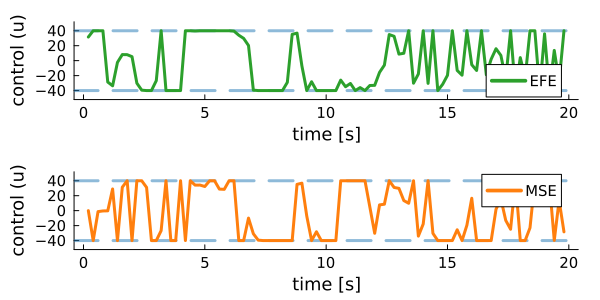

In [37]:
p1 = hline([sys_ulims[1]], color=palette(:tab10)[1], linestyle=:dash, alpha=0.5)
hline!([sys_ulims[2]], color=palette(:tab10)[1], linestyle=:dash, alpha=0.5)
plot!(tsteps[2:end], u_MSE[2:end-T], linewidth=3, color=palette(:tab10)[2], label="MSE", ylims=sys_ulims.*1.3, xlabel="time [s]", ylabel="control (u)", guidefontsize=12, legendfontsize=10, tickfontsize=10)

p2 = hline([sys_ulims[1]], color=palette(:tab10)[1], linestyle=:dash, alpha=0.5)
hline!([sys_ulims[2]], color=palette(:tab10)[1], linestyle=:dash, alpha=0.5)
plot!(tsteps[2:end], u_EFE[2:end-T], linewidth=3, color=palette(:tab10)[3], label="EFE", ylims=sys_ulims.*1.3, xlabel="time [s]", ylabel="control (u)", guidefontsize=12, legendfontsize=10, tickfontsize=10)

plot(p2,p1, layout=grid(2,1, heights=[.5, .5]), size=(600,300), margin=10Plots.pt)